In [ ]:
import torch
import numpy as np
import skimage.io
import skimage
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import random
%matplotlib inline
%env CUDA_VISIBLE_DEVICES=1

In [ ]:
random.seed(38)
torch.manual_seed(38)
# use for random generation
up = np.ones(10)
down = np.zeros(10)
fixed_class = np.hstack((up,down))
fixed_class = torch.from_numpy(fixed_class).view(20,1,1,1).type(torch.FloatTensor)
fixed_noise = torch.randn(10, 100, 1, 1)
fixed_noise = torch.cat((fixed_noise,fixed_noise))
fixed_input = Variable(torch.cat((fixed_noise, fixed_class),1)).cuda()

In [ ]:
# load data
train_X = np.load("all_img_flip.npy")
train_attr = pd.read_csv("./hw4_data/train.csv")
test_attr = pd.read_csv("./hw4_data/test.csv")

smiling_attr = np.hstack((np.repeat(np.array(train_attr["Smiling"]),2) 
                          ,np.repeat(np.array(test_attr["Smiling"]),2)
                         ))

In [ ]:
# type transform
img_X = torch.from_numpy(train_X).type(torch.FloatTensor)
class_X = torch.from_numpy(smiling_attr).type(torch.FloatTensor).view(-1,1,1,1)

In [ ]:
class Generator(nn.Module):
    def __init__(self, figsize=64):
        super(Generator, self).__init__()
        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( 101, figsize * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(figsize * 8),
            nn.ReLU(inplace=True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(figsize * 8, figsize * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize * 4),
            nn.ReLU(inplace=True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(figsize * 4, figsize * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize * 2),
            nn.ReLU(inplace=True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(figsize * 2, figsize, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize),
            nn.ReLU(inplace=True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(figsize, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, X):
        output = self.decoder(X)/2.0+0.5
        return output
    
class Discriminator(nn.Module):
    def __init__(self, figsize=64):
        super(Discriminator, self).__init__()
        self.decoder = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, figsize, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(figsize, figsize * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(figsize * 2, figsize * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(figsize * 4, figsize * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(figsize * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(figsize * 8, 1, 4, 1, 0, bias=False),
        )
        self.fc_dis = nn.Linear(1, 1)
        # aux-classifier fc
        self.fc_aux = nn.Linear(1, 1) # one class
        
        # softmax and sigmoid
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()
    def forward(self, X):
        decode_output = self.decoder(X)

        flat = decode_output.view(-1,1)
        fc_dis = self.fc_dis(flat)
        fc_aux = self.fc_aux(flat)
        
        realfake = self.sigmoid(fc_dis)
        classes = self.sigmoid(fc_aux)
        
        return realfake, classes

In [ ]:
# loss functions
dis_criterion = nn.BCELoss()
aux_criterion = nn.BCELoss()

# training
latent_size = 100
BATCH_SIZE = 64
G = Generator().cuda()
D = Discriminator().cuda()
# setup optimizer
optimizerG = optim.Adam(G.parameters(), lr=0.0002)
optimizerD = optim.Adam(D.parameters(), lr=0.0002)


D_loss_list = []
G_loss_list = []
D_fake_acc_list = []
D_real_acc_list = []

D_fake_class_list = []
D_real_class_list = []
for epoch in range(100):
    print("Epoch:", epoch+1)
    epoch_D_loss = 0.0
    epoch_G_loss = 0.0
    D_fake_acc = 0.0
    D_real_acc = 0.0
    D_fake_class = 0.0
    D_real_class = 0.0
    total_length = len(train_X)
    # shuffle
    perm_index = torch.randperm(total_length)
    train_X_sfl = img_X[perm_index]
    train_class_sfl = class_X[perm_index]
    # construct training batch
    for index in range(0,total_length ,BATCH_SIZE):
        if index+BATCH_SIZE > total_length:
            break
            
        # zero the parameter gradients
        D.zero_grad()
        input_X = train_X_sfl[index:index+BATCH_SIZE]
        intput_class = train_class_sfl[index:index+BATCH_SIZE]
        #### train with real image -> ground truth = real label
        real_image = Variable(input_X.cuda()) # use GPU 
        real_class = Variable(intput_class.cuda())
        real_label = Variable(torch.ones((BATCH_SIZE))).cuda()
        dis_ouput, aux_output = D(real_image)
        D_real_dis_loss = dis_criterion(dis_ouput, real_label.view(BATCH_SIZE,1))
        D_real_aux_loss = aux_criterion(aux_output, real_class.view(BATCH_SIZE,1))
        D_real_acc += np.mean(((dis_ouput > 0.5).cpu().data.numpy() == real_label.cpu().data.numpy()))
        D_real_loss = (D_real_dis_loss + D_real_aux_loss)/2
        D_real_class += D_real_aux_loss.data[0]
        #### train with fake image -> ground truth = fake label
        noise = torch.randn(BATCH_SIZE, 100, 1, 1)
        fake_class = torch.from_numpy(np.random.randint(2,size=BATCH_SIZE)).view(BATCH_SIZE,1,1,1)
        intput_vector =Variable(torch.cat((noise,fake_class.type(torch.FloatTensor)),1)).cuda()
        
        fake_label = Variable(torch.zeros((BATCH_SIZE))).cuda()
        fake_class = Variable(fake_class.type(torch.FloatTensor)).cuda()
        
        fake_image = G(intput_vector)
        dis_output, aux_output = D(fake_image.detach())
        D_fake_dis_loss = dis_criterion(dis_output, fake_label.view(BATCH_SIZE,1))
        D_fake_aux_loss = aux_criterion(aux_output, fake_class.view(BATCH_SIZE,1))
        D_fake_loss = (D_fake_dis_loss + D_fake_aux_loss)/2
        D_fake_acc += np.mean(((dis_output > 0.5).cpu().data.numpy() == fake_label.cpu().data.numpy()))
        D_fake_class += D_fake_aux_loss.data[0]
        # update D
        D_train_loss = D_real_loss + D_fake_loss
        D_train_loss.backward()
        epoch_D_loss+=(D_train_loss.data[0])
        
        optimizerD.step()
        
        #### train Generator
        
        G.zero_grad()
        # generate fake image
        noise = torch.randn(BATCH_SIZE, 100, 1, 1)
        fake_class = torch.from_numpy(np.random.randint(2,size=BATCH_SIZE)).view(BATCH_SIZE,1,1,1)

        intput_vector = Variable(torch.cat((noise,fake_class.type(torch.FloatTensor)),1)).cuda()
        
        fake_class = Variable(fake_class.type(torch.FloatTensor)).cuda()
        fake_label_for_G = Variable(torch.ones((BATCH_SIZE))).cuda()
        
        fake_image = G(intput_vector)
        dis_output, aux_output = D(fake_image)
        G_dis_loss = dis_criterion(dis_output, fake_label_for_G.view(BATCH_SIZE,1))
        G_aux_loss = aux_criterion(aux_output, fake_class.view(BATCH_SIZE,1))
        G_train_loss = G_dis_loss + G_aux_loss
        epoch_G_loss += (G_train_loss.data[0])
        G_train_loss.backward()
        optimizerG.step()
        
    print("training D Loss:",epoch_D_loss/(total_length))
    print("training G Loss:", epoch_G_loss/(total_length))
    D_loss_list.append(epoch_D_loss/(total_length))
    G_loss_list.append(epoch_G_loss/(total_length))
    
    print("D_real_dis_acc:", D_real_acc/(total_length/BATCH_SIZE))
    print("D_fake_dis_acc:", D_fake_acc/(total_length/BATCH_SIZE))
    print("D_real_aux_loss:", D_real_class/(total_length/BATCH_SIZE))
    print("D_fake_aux_loss:", D_fake_class/(total_length/BATCH_SIZE))
    D_real_acc_list.append(D_real_acc/(total_length/BATCH_SIZE))
    D_fake_acc_list.append(D_fake_acc/(total_length/BATCH_SIZE))    
    D_real_class_list.append(D_real_class/(total_length/BATCH_SIZE))
    D_fake_class_list.append(D_fake_class/(total_length/BATCH_SIZE))
    # evaluation
    G.eval()
    fixed_img_output = G(fixed_input)
    G.train()
    torchvision.utils.save_image(fixed_img_output.cpu().data, './ACGAN_output/fig3_3_'+str(epoch+1)+'.jpg',nrow=10)
    
torch.save(G.state_dict(), "./models/ACG_model.pkt")

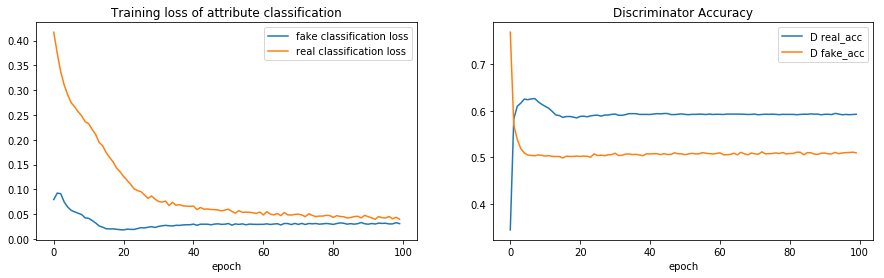

In [21]:
# plot loss
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(D_fake_class_list, label="fake classification loss")
plt.plot(D_real_class_list, label="real classification loss")
plt.title("Training loss of attribute classification")
plt.xlabel("epoch")
plt.legend()

plt.subplot(1,2,2)
plt.plot(D_real_acc_list, label="D real_acc")
plt.plot(D_fake_acc_list, label="D fake_acc")
plt.title("Discriminator Accuracy")
plt.xlabel("epoch")
plt.legend()
plt.savefig("./ACGAN_output/fig3_2.jpg")
plt.show()